# Libraries used

Running Kernel3.9.13 base anaconda

pip install squarify
pip install yellowbrick
pip install plotly
pip install seaborn
pip install lazypredict
pip install pandas_profiling

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
import plotly.io as pio
import squarify #treemap
import os
import matplotlib
import warnings

#to enable the inline plotting
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

In [4]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler


from scipy.stats import normaltest

from pandas_profiling import ProfileReport

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette

import lazypredict

warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Data Collection and Understanding 

## Network file

The network.csv file contains a static picture of the gas pipeline network. Every row corresponds to a pipe and has a unique PipeId identifier. The table has 1.446.529 pipes. 

The columns describe relevant features of each pipe. The complete list is: 

PipeId - unique identifier for the pipe 

Province - Spanish province where the pipe is located 

Town - Town or city where the pipe is located 

YearBuilt - Year in which the pipe was built and installed 

Material - Material in which the pipe is built 

GasType - Type of gas that runs through the pipe 

Diameter - diameter of the pipe 

Length - Length of the pipe 

Pressure - Pressure of the gas that runs through the pipe (bar) 

NumConnections - Number of connections (external). 

NumConnectionsUnder - Number of connections (internal and buried) 

BoolBridle  - Whether the pipe is bridled (True) or welded (False) 

## Inspection file

MaintenanceId - unique identifier for the inspection operation 

InspectionYear - year in which the inspection took place 

InspectionDate - date in which the inspection took place 

MonthsLastRev - number of months elapsed since the last previous inspection. 

Severity - Severity of the damage found (1: most severe, 3: least severe) 

Incidence - Boolean whether an incident was found on the revision (1) or not (0). 

# Merging datasets

In [6]:
#point to the folder where the data is stored
os.chdir(r"C:\Users\pedro\datathon")

# Loading inspection data
df_inspection = pd.read_csv('inspections.csv')

# Loading network data
df_network = pd.read_csv('network.csv')

In [7]:
#merge both dataframes

df_combined = pd.merge(df_inspection, df_network, on="PipeId")

In [5]:
df_combined.head(1)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.0,0,0,False


In [6]:
#CExporting the combined data to csv file
#df_combined.to_csv('df_pipes_combined.csv', index = False)
#DOING AT THE END OF PIPELINE

In [8]:
#creating a subset for altering the dataset after initial EDA
df_combined_mod = df_combined.copy()

# Descriptive EDA on combined dataframe

In [9]:
df_combined['BoolBridle'].describe()

count     6345344
unique          2
top         False
freq      5967747
Name: BoolBridle, dtype: object

In [10]:
# Function for EDA. Using the display() function to have  well-formatted tables. We are mainly using pandas to explore the datasets

def dataset_description(df_target):

    print('This is the Dataset shape: %s\n' % (df_target.shape, ))
    print('Dataset columns: %s\n' % df_target.columns)

    print('\nColumns description:\n')
    display(df_target.info())
    display(df_target.describe())  # describe the dataset

    print('\nNull values:\n')
    display(df_target.isnull().sum())  # Identify null values

In [11]:
dataset_description(df_combined)

This is the Dataset shape: (6345344, 18)

Dataset columns: Index(['PipeId', 'MaintenanceId', 'InspectionYear', 'InspectionDate',
       'MonthsLastRev', 'Severity', 'Incidence', 'Province', 'Town',
       'YearBuilt', 'Material', 'GasType', 'Diameter', 'Length', 'Pressure',
       'NumConnections', 'NumConnectionsUnder', 'BoolBridle'],
      dtype='object')


Columns description:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6345344 entries, 0 to 6345343
Data columns (total 18 columns):
 #   Column               Dtype  
---  ------               -----  
 0   PipeId               int64  
 1   MaintenanceId        object 
 2   InspectionYear       int64  
 3   InspectionDate       object 
 4   MonthsLastRev        int64  
 5   Severity             int64  
 6   Incidence            int64  
 7   Province             object 
 8   Town                 object 
 9   YearBuilt            int64  
 10  Material             object 
 11  GasType              object 
 12  Diameter             f

None

,PipeId,InspectionYear,MonthsLastRev,Severity,Incidence,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder
count,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06
mean,2.031281e+08,2.015609e+03,2.349061e+01,3.997426e+00,1.942842e-03,2.001037e+03,1.195482e+02,3.653018e+01,2.906349e+00,9.842453e-01,2.229982e-04
std,1.137699e+08,2.909342e+00,4.961511e+00,6.451558e-02,4.403484e-02,1.196869e+01,5.721421e+01,7.214106e+01,6.572514e+00,2.140921e+00,1.613866e-02
min,4.896160e+05,2.010000e+03,0.000000e+00,1.000000e+00,0.000000e+00,1.901000e+03,1.000000e+01,0.000000e+00,2.500000e-02,0.000000e+00,0.000000e+00
25%,1.335933e+08,2.013000e+03,2.300000e+01,4.000000e+00,0.000000e+00,1.997000e+03,9.000000e+01,4.005000e+00,1.000000e-01,0.000000e+00,0.000000e+00
50%,1.903213e+08,2.016000e+03,2.400000e+01,4.000000e+00,0.000000e+00,2.003000e+03,1.100000e+02,1.426200e+01,1.500000e-01,0.000000e+00,0.000000e+00
75%,2.981763e+08,2.018000e+03,2.400000e+01,4.000000e+00,0.000000e+00,2.008000e+03,1.600000e+02,4.460100e+01,4.000000e+00,1.000000e+00,0.000000e+00
max,4.519953e+08,2.021000e+03,1.320000e+02,4.000000e+00,1.000000e+00,2.050000e+03,6.096000e+02,2.610094e+04,8.000000e+01,8.800000e+01,4.000000e+00



Null values:



PipeId                 0
MaintenanceId          0
InspectionYear         0
InspectionDate         0
MonthsLastRev          0
Severity               0
Incidence              0
Province               0
Town                   0
YearBuilt              0
Material               0
GasType                0
Diameter               0
Length                 0
Pressure               0
NumConnections         0
NumConnectionsUnder    0
BoolBridle             0
dtype: int64

# Data Wrangling

In [12]:
# Converting Boolbride into categorical boolean variable
def boolbridle(x):
    return 1 if x == 'True' else 0

In [13]:
# Apply function on dataset
df_combined['BoolBridle'] = df_combined['BoolBridle'].apply(lambda x: boolbridle(x))

In [15]:
#showing head
df_combined.head(1)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.0,0,0,0


In [16]:
#Convert InspectionDate to datetime
df_combined['InspectionDate'] = pd.to_datetime(df_combined['InspectionDate'])

In [18]:
#Extract the day of the week from InspectionDate
df_combined['InspectionDay'] = df_combined['InspectionDate'].dt.day_name()
df_combined.head(1)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionDay
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.0,0,0,0,Friday


In [16]:
#show columns
df_combined.dtypes


PipeId                   int64
MaintenanceId           object
InspectionYear           int64
InspectionDate          object
MonthsLastRev            int64
Severity                 int64
Incidence                int64
Province                object
Town                    object
YearBuilt                int64
Material                object
GasType                 object
Diameter               float64
Length                 float64
Pressure               float64
NumConnections           int64
NumConnectionsUnder      int64
BoolBridle               int64
dtype: object

In [19]:
#hot encode GasType column in the df_combined_mod dataframe subset
df_combined_mod = pd.get_dummies(df_combined, columns=['GasType'], prefix = ['GasType'])

In [21]:
#delete GasType_Gas propano column
df_combined_mod = df_combined_mod.drop(['GasType_Gas propano'], axis=1)

In [22]:
#change name of GasType_Gas natural column to gas_natural
df_combined_mod = df_combined_mod.rename(columns={'GasType_Gas natural': 'gas_natural'})
df_combined_mod.head(1)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionDay,gas_natural
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0,Barcelona,Sentmenat,2001,PE,160.0,117.831,4.0,0,0,0,Friday,1


We want to also see materials available for the pipes as a hot encoded feature

In [23]:
print (df_combined['Material'].unique())

['PE' 'AO' 'FD' 'FG' 'PN' 'PA' 'FO' 'FI' 'CU' 'PV' 'ZD']


In [24]:
#Map df_combined Material column to the names of materials

df_combined_mod['Material'] = df_combined_mod['Material'].map({'PE': 'Polyethylene', 'AO': 'Acrylonitrile-Butadiene-Styrene', 'FD': 'Fiberglass-Reinforced Plastic', 'FG': 'Fiberglass', 'PN': 'Polypropylene', 'PA': 'Polyamide', 'FO': 'Flexible Polyolefin', 'FI': 'Flexible Polyvinyl Chloride', 'CU': 'Copper', 'PV': 'Polyvinylidene Fluoride', 'ZD': 'Zinc-Coated Steel', 'ZA': 'Zinc-Aluminum', 'CP': 'Cast Iron', 'CS': 'Cast Steel', 'ZC': 'Zinc-Coated Steel', 'ZM': 'Zinc-Magnesium', 'ZN': 'Zinc', 'AL': 'Aluminum', 'ZP': 'Zinc-Coated Steel', 'ZF': 'Zinc-Aluminum-Magnesium'})



In [26]:
df_combined_mod.tail(1)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionDay,gas_natural
6345343,56922465,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,1993,Polyethylene,63.0,1.778,4.0,0,0,0,Thursday,1


In [27]:
#Hot enconde Material column in the df_combined_mod dataframe subset
df_combined_mod = pd.get_dummies(df_combined_mod, columns=['Material'], prefix = ['Material'])

In [30]:
#allow to see all columns in pandas
pd.set_option('display.max_columns', None)
df_combined_mod.head(1)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionDay,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass,Material_Fiberglass-Reinforced Plastic,Material_Flexible Polyolefin,Material_Flexible Polyvinyl Chloride,Material_Polyamide,Material_Polyethylene,Material_Polypropylene,Material_Polyvinylidene Fluoride,Material_Zinc-Coated Steel
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0,Barcelona,Sentmenat,2001,160.0,117.831,4.0,0,0,0,Friday,1,0,0,0,0,0,0,0,1,0,0,0


In [31]:
#deleting columns Material_Fiberglass, Material_Zinc_coated_steel, Material_Polyvinylidene_fluoride
df_combined_mod = df_combined_mod.drop(['Material_Fiberglass', 'Material_Zinc-Coated Steel', 'Material_Polyvinylidene Fluoride'], axis=1)

In [33]:
#deleting columns Material_Flexible Polyolefin,Material_Flexible Polyvinyl Chloride, Material_Polyamide
df_combined_mod = df_combined_mod.drop(['Material_Flexible Polyolefin', 'Material_Flexible Polyvinyl Chloride', 'Material_Polyamide'], axis=1)
df_combined_mod.head(1)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionDay,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0,Barcelona,Sentmenat,2001,160.0,117.831,4.0,0,0,0,Friday,1,0,0,0,1,0


In [34]:
#delete outliers in year_built column to keep values only higher than 1960
df_combined_mod = df_combined_mod[df_combined_mod['YearBuilt'] > 1960]


In [44]:
df_combined_mod.dtypes

PipeId                                               int64
MaintenanceId                                       object
InspectionYear                                       int64
InspectionDate                              datetime64[ns]
MonthsLastRev                                        int64
Severity                                             int64
Province                                            object
Town                                                object
YearBuilt                                            int64
Diameter                                           float64
Length                                             float64
Pressure                                           float64
NumConnections                                       int64
NumConnectionsUnder                                  int64
BoolBridle                                           int64
InspectionDay                                       object
gas_natural                                          uin

In [47]:
#display possible values for week_day column and how many times they appear
df_combined_mod['InspectionDay'].value_counts()

Tuesday      1334236
Wednesday    1314102
Monday       1269454
Thursday     1237359
Friday        915481
Saturday      101252
Sunday         79192
Name: InspectionDay, dtype: int64

In [51]:
#eliminate values higher than 40 in MonthsLastRev column
df_combined_mod = df_combined_mod[df_combined_mod['MonthsLastRev'] < 40]

<AxesSubplot: >

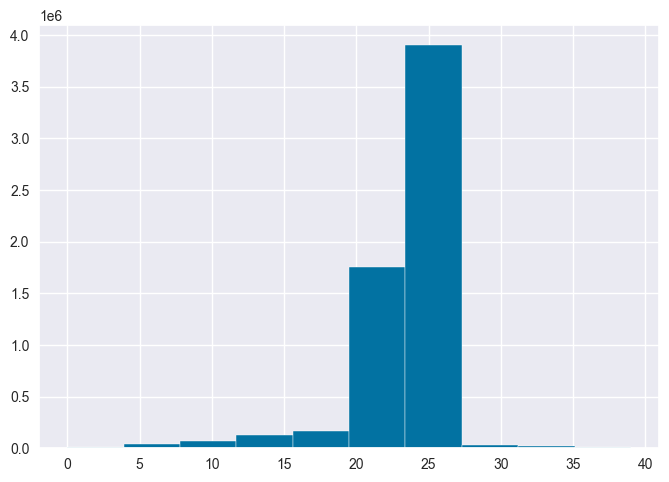

In [52]:
#graph histogram of MonthsLastRev column
df_combined_mod['MonthsLastRev'].hist()

In [53]:
#eliminate values higher than 400 in diameter column
df_combined_mod = df_combined_mod[df_combined_mod['Diameter'] < 400]

<AxesSubplot: >

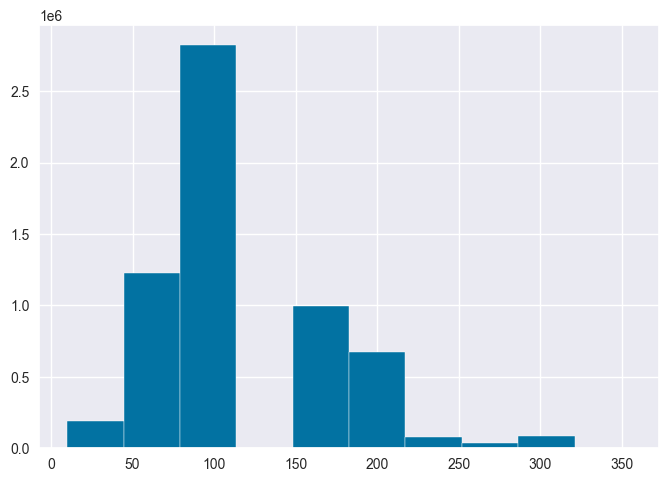

In [54]:
#show histogram of diameter column
df_combined_mod['Diameter'].hist()

In [71]:
#plot column Length
df_combined_mod['Length'].value_counts()

2.000      26542
1.000      25356
1.002      18865
0.500      18446
1.500      17986
           ...  
93.239         1
165.090        1
143.132        1
130.399        1
134.322        1
Name: Length, Length: 204118, dtype: int64

<AxesSubplot: >

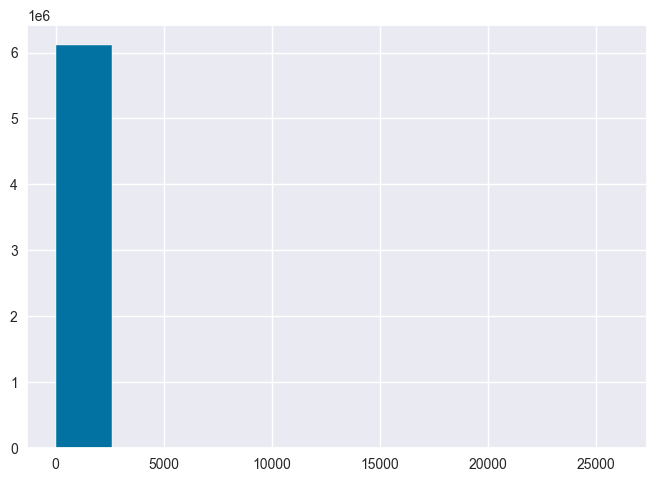

In [72]:
#plot histogram of Length column
df_combined_mod['Length'].hist()

# Feature Engineering

In [35]:
#create a new column that divides the diameter by the pressure and name it Relative Thickness
df_combined_mod['Relative_Thickness'] = df_combined_mod['Diameter'] / df_combined_mod['Pressure']

In [48]:
#Create a new column that takes the inspecion year and substracts the YearBuilt column naming it Age of Pipe
df_combined_mod['Age_of_Pipe_upon_inspection'] = df_combined_mod['InspectionYear'] - df_combined_mod['YearBuilt']
df_combined_mod.head(1)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionDay,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Relative_Thickness,Severity_Incidence,Age_of_Pipe_upon_inspection
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,Barcelona,Sentmenat,2001,160.0,117.831,4.0,0,0,0,Friday,1,0,0,0,1,0,40.0,0,9


In [36]:
#create a column that multiplies severity by incidence and name it severity_incidence
df_combined_mod['Severity_Incidence'] = df_combined_mod['Severity'] * df_combined_mod['Incidence']

In [37]:
#delete column incidence
df_combined_mod = df_combined_mod.drop(['Incidence'], axis=1)

In [59]:
#delete column severity
df_combined_mod = df_combined_mod.drop(['Severity'], axis=1)
df_combined_mod.head(1)


,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionDay,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Relative_Thickness,Age_of_Pipe_upon_inspection,Severity_0,Severity_low,Severity_medium,Severity_high
0,189311802,ZRV-00001972,2010,2010-10-01,24,Barcelona,Sentmenat,2001,160.0,117.831,4.0,0,0,0,Friday,1,0,0,0,1,0,40.0,9,1,0,0,0


In [60]:
df_combined_mod.dtypes

PipeId                                               int64
MaintenanceId                                       object
InspectionYear                                       int64
InspectionDate                              datetime64[ns]
MonthsLastRev                                        int64
Province                                            object
Town                                                object
YearBuilt                                            int64
Diameter                                           float64
Length                                             float64
Pressure                                           float64
NumConnections                                       int64
NumConnectionsUnder                                  int64
BoolBridle                                           int64
InspectionDay                                       object
gas_natural                                          uint8
Material_Acrylonitrile-Butadiene-Styrene             uin

In [49]:
#hot encode severity_incidence column in the df_combined_mod dataframe
df_combined_mod = pd.get_dummies(df_combined_mod, columns=['Severity_Incidence'], prefix = ['Severity_Incidence'])
df_combined_mod.head(1)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionDay,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Relative_Thickness,Age_of_Pipe_upon_inspection,Severity_Incidence_0,Severity_Incidence_1,Severity_Incidence_2,Severity_Incidence_3
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,Barcelona,Sentmenat,2001,160.0,117.831,4.0,0,0,0,Friday,1,0,0,0,1,0,40.0,9,1,0,0,0


In [50]:
#change name of Severity_Incidence_0 column to Severity_0
df_combined_mod = df_combined_mod.rename(columns={'Severity_Incidence_0': 'Severity_0'})
#change name of Severity_Incidence_1 column to Severity_low
df_combined_mod = df_combined_mod.rename(columns={'Severity_Incidence_1': 'Severity_low'})
#change name of Severity_Incidence_2 column to Severity_medium
df_combined_mod = df_combined_mod.rename(columns={'Severity_Incidence_2': 'Severity_medium'})
#change name of Severity_Incidence_3 column to Severity_high
df_combined_mod = df_combined_mod.rename(columns={'Severity_Incidence_3': 'Severity_high'})
df_combined_mod.head(1)


,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionDay,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Relative_Thickness,Age_of_Pipe_upon_inspection,Severity_0,Severity_low,Severity_medium,Severity_high
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,Barcelona,Sentmenat,2001,160.0,117.831,4.0,0,0,0,Friday,1,0,0,0,1,0,40.0,9,1,0,0,0


In [62]:
df_combined_mod.shape

(6114918, 27)

In [63]:
#General number of high severity per year
df_combined_mod.groupby('InspectionYear')['Severity_high'].value_counts()

InspectionYear  Severity_high
2010            0                 91831
                1                    12
2011            0                506105
                1                   899
2012            0                591783
                1                   924
2013            0                559868
                1                   735
2014            0                575800
                1                   670
2015            0                593991
                1                   543
2016            0                606081
                1                   828
2017            0                656796
                1                  1416
2018            0                628830
                1                   904
2019            0                663457
                1                  1018
2020            0                630366
                1                   779
2021            0                  1280
                1                     2
Name: Seve

In [66]:
df_combined_mod.dtypes

PipeId                                               int64
MaintenanceId                                       object
InspectionYear                                       int64
InspectionDate                              datetime64[ns]
MonthsLastRev                                        int64
Province                                            object
Town                                                object
YearBuilt                                            int64
Diameter                                           float64
Length                                             float64
Pressure                                           float64
NumConnections                                       int64
NumConnectionsUnder                                  int64
BoolBridle                                           int64
InspectionDay                                       object
gas_natural                                          uint8
Material_Acrylonitrile-Butadiene-Styrene             uin

# Exporting the new dataset for a backup

In [73]:
#point to the folder where the data is stored
os.chdir(r"C:\Users\pedro\datathon")
#export the dataframe to a csv file
df_combined_mod.to_csv('df_combined_mod.csv', index=False)

# Plotting EDA for new dataset

In [75]:
#pandas profiling on the df_combined_mod dataframe
profile = ProfileReport(df_combined_mod, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

# Baseline for df_combined alone 
df__combined_mod reached 86% and locked after230 min

In [54]:
#make a new dataframe removing columns that are not needed for the model from the df_combined_mod dataframe
df_model = df_combined_mod.drop(['InspectionYear', 'MaintenanceId', 'Province', 'Town', 'InspectionDate'], axis=1)


In [55]:
df_model.head(2)

,PipeId,MonthsLastRev,Incidence,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,GasType_Gas natural,GasType_Gas propano,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass,Material_Fiberglass-Reinforced Plastic,Material_Flexible Polyolefin,Material_Flexible Polyvinyl Chloride,Material_Polyamide,Material_Polyethylene,Material_Polypropylene,Material_Polyvinylidene Fluoride,Material_Zinc-Coated Steel,Severity_Low,Severity_Medium,Severity_High,Severity_Critical,Age_of_Pipe,Relative_Thickness
0,189311802,24,0,2001,160.0,117.831,4.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,22,40.0
1,189311802,24,0,2001,160.0,117.831,4.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,22,40.0


In [56]:
#split df_combined_mod into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_model.drop(['Incidence'], axis=1), df_model['Incidence'], test_size=0.2, random_state=42)


In [57]:
#use lazy predict to create a baseline with all possible models
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=1, ignore_warnings=False, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

  3%|▎         | 1/29 [00:12<05:58, 12.80s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 1.0, 'Balanced Accuracy': 1.0, 'ROC AUC': 1.0, 'F1 Score': 1.0, 'Time taken': 12.795071363449097}


  7%|▋         | 2/29 [01:08<17:05, 37.99s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 1.0, 'Balanced Accuracy': 1.0, 'ROC AUC': 1.0, 'F1 Score': 1.0, 'Time taken': 55.61998963356018}


 10%|█         | 3/29 [01:16<10:30, 24.23s/it]

{'Model': 'BernoulliNB', 'Accuracy': 1.0, 'Balanced Accuracy': 1.0, 'ROC AUC': 1.0, 'F1 Score': 1.0, 'Time taken': 7.86034369468689}


In [65]:
#split df_combined_mod into train and test set
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(df_combined_mod.drop(['Incidence'], axis=1), df_combined_mod['Incidence'], test_size=0.2, random_state=42)


In [67]:
#use lazy predict to create a baseline with all possible models
#from lazypredict.Supervised import LazyClassifier
#clf = LazyClassifier(verbose=1, ignore_warnings=False, custom_metric=None)
#models, predictions = clf.fit(X_train, X_test, y_train, y_test)
#models

 86%|████████▌ | 25/29 [35:56<05:54, 88.59s/it]  

# DO NOT TOUCH SECTION :)
# After creating baseline, normalizing and stratyfing, in that order

In [64]:
df_combined_mod_norm = df_combined_mod.copy()

In [ ]:
#apply normalization and standardization to the df_combined_mod_norm dataframe
for i in df_combined_mod_norm.columns:
    if 'Material' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Severity' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Incidence' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Age_of_Pipe' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Relative_Thickness' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Diameter' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Pressure' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'YearBuilt' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'InspectionYear' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Material_Cast Iron' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Material_Concrete' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Material_Fiberglass' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm

In [63]:
#apply synthetic minority oversampling technique to balance the data ignoring categorical variables
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=0)
X_sm, y_sm = smote.fit_resample(df_combined_mod.drop(['Incidence'], axis=1), df_combined_mod['Incidence'])


ValueError: could not convert string to float: 'ZRV-00001972'